<a href="https://colab.research.google.com/github/shengjiyang/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [10]:
# Write a function:
# def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):

# What is the probability that a person is drunk
# after one positive breathalyzer test?

p_pos_cond_drunk = 1

def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):
  numerator = (p_pos_cond_drunk * prob_drunk_prior)
  denominator = numerator + (false_positive_rate * (1 - prob_drunk_prior))
  return numerator / denominator

prob_drunk_given_positive(1 / 1000, 0.08)

# The probability that someone is drunk given a single positive test
# being 1.24% seems wrong, but maybe...

0.012357884330202669

In [22]:
print(1, prob_drunk_given_positive(1 / 1000, 0.08))
print(2, prob_drunk_given_positive(0.012357884330202669, 0.08))
print(3, prob_drunk_given_positive(0.13525210993291495, 0.08))
print(4, prob_drunk_given_positive(0.6615996951348605, 0.08))
print(5, prob_drunk_given_positive(0.9606895076105054, 0.08))
print(6, prob_drunk_given_positive(0.9967371577896734, 0.08))
print(7, prob_drunk_given_positive(0.9997381867081508, 0.08))

# It would require 4 tests in order to be 95% certain of an
# individual's drunkness from a brethalyzer test,
# 7 tests to be near 100% certain.

1 0.012357884330202669
2 0.13525210993291495
3 0.6615996951348605
4 0.9606895076105054
5 0.9967371577896734
6 0.9997381867081508
7 0.9999790498904363


In [0]:
# Explore scipy.stats.bayes_mvs

# Create a visualization comparing the results of a Bayesian approach to a
# traditional/frequentist approach. (with a large sample size they should look
# close to identical, however, take this opportunity to practice visualizing
# condfidence intervals in general. The following are some potential ways that
# you could visualize confidence intervals on your graph:


# For this I am going to compare the frequentist confidence intervals calculated
# yesterday from the Voting_Data dataset with their Bayesian equivalents.

import pandas as pd
import numpy as np

column_headers = ['party', 'handicapped-infants',
                  'water-project-cost-sharing',
                  'adoption-of-the-budget-resolution', 'physician-fee-freeze',
                  'el-salvador-aid', 'religious-groups-in-schools',
                  'anti-satellite-test-ban', 'aid-to-nicaraguan-contras',
                  'mx-missile', 'immigration', 'synfuels-corporation-cutback',
                  'education-spending', 'superfund-right-to-sue', 'crime',
                  'duty-free-exports', 'export-administration-act-south-africa']

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',
                          names = column_headers)

In [24]:
df = df.replace('y', 1).replace('n', 0)
df.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0,1,0,1,1,1,0,0,0,1,?,1,1,1,0,1
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,?
2,democrat,?,1,1,?,1,1,0,0,0,0,1,0,1,1,0,0
3,democrat,0,1,1,0,?,1,0,0,0,0,1,0,1,0,0,1
4,democrat,1,1,1,0,1,1,0,0,0,0,1,?,1,1,1,1


In [0]:
# Original Frequentist Confidence Interval Function

from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

In [0]:
rep = df[df['party'] == 'republican']
dem = df[df['party'] == 'democrat']

In [32]:
# Building a Confidence Interval for Republican for and against the
# "Handicapped Infants" resolution.

# From the documentation fro DataFrame.drop():
# dfObj.drop( dfObj[ dfObj['Age'] == 30 ].index , inplace=True)

rep['handicapped-infants'].drop(rep['handicapped-infants'][rep['handicapped-infants'] == '?'].index, inplace = True)
rep['handicapped-infants'].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


0    134
1     31
Name: handicapped-infants, dtype: int64

In [33]:
mean, lower, upper = confidence_interval(rep['handicapped-infants'])

print(mean, [lower, upper])

0.18787878787878787 [0.12765166444807918, 0.24810591130949655]


In [72]:
# Frequentist Error for Republicans

0.24810591130949655 - 0.18787878787878787

0.060227123430708684

In [37]:
# Bayesian CI for Republicans

Mean_CIR, Variance_CIR, Std_dev_CIR = stats.bayes_mvs(rep['handicapped-infants'])
print(Mean_CIR)

Mean(statistic=0.18787878787878787, minmax=(0.13742255172114007, 0.23833502403643564))


In [73]:
# Bayesian Error for Republicans

0.23833502403643564 - 0.18787878787878787

0.05045623615764777

In [34]:
# Now for Democrats on the same issue:

dem['handicapped-infants'].drop(dem['handicapped-infants'][dem['handicapped-infants'] == '?'].index, inplace = True)
dem['handicapped-infants'].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


1    156
0    102
Name: handicapped-infants, dtype: int64

In [35]:
mean, lower, upper = confidence_interval(dem['handicapped-infants'])

print(mean, [lower, upper])

0.6046511627906976 [0.5445926997425515, 0.6647096258388437]


In [68]:
# Frequentist Error fro the Democrats

0.6647096258388437 - 0.6046511627906976

0.060058463048146105

In [38]:
# Bayesian CI for Democrats

# Democrats
Mean_CID, Variance_CID, Std_dev_CID = stats.bayes_mvs(dem['handicapped-infants'])
Mean_CID

Mean(statistic=0.6046511627906976, minmax=(0.5543043832674934, 0.6549979423139018))

In [39]:
# Bayesian Error for the Democrats
0.6549979423139018 - 0.6046511627906976

0.05034677952320421

In [31]:
# Visualization of Confidence Intervals

rep_yays = rep['handicapped-infants'][rep['handicapped-infants'] == 1]
rep_yays.value_counts()

1    31
Name: handicapped-infants, dtype: int64

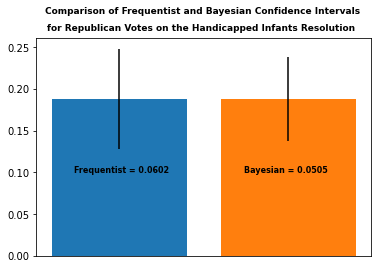

In [101]:
# Comparative Visualization of
# Frequentist vs. Bayesian Confidence Intervals

# Republican

import matplotlib.pyplot as plt
import seaborn as sns

ax, fig = plt.subplots()
ax = plt.axes()

ax.text(s = "Comparison of Frequentist and Bayesian Confidence Intervals",
        x = -0.44, y = 0.29, fontsize = 9, fontweight = 'bold')
ax.text(s = "for Republican Votes on the Handicapped Infants Resolution",
        x = -0.425, y = 0.27, fontsize = 9, fontweight = 'bold')

ax.get_xaxis().set_visible(False)

ax.text(s = "Frequentist = 0.0602", x = -0.265, y =0.1, fontsize = 8,
        fontweight = 'bold')

ax.text(s = "Bayesian = 0.0505", x = 0.74, y =0.1, fontsize = 8,
        fontweight = 'bold')

plt.bar(0, 0.18787878787878787, yerr = 0.060227123430708684)
plt.bar(1, 0.18787878787878787, yerr = 0.05045623615764777);

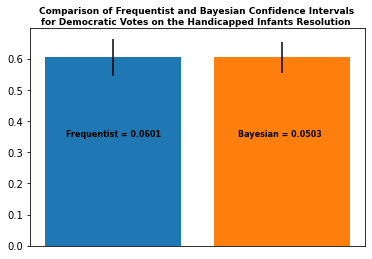

In [104]:
# Comparative Visualization of
# Frequentist vs. Bayesian Confidence Intervals

# Democrat

ax, fig = plt.subplots()
ax = plt.axes()

ax.text(s = "Comparison of Frequentist and Bayesian Confidence Intervals",
        x = -0.44, y = 0.745, fontsize = 9, fontweight = 'bold')
ax.text(s = "for Democratic Votes on the Handicapped Infants Resolution",
        x = -0.425, y = 0.71, fontsize = 9, fontweight = 'bold')

ax.get_xaxis().set_visible(False)

ax.text(s = "Frequentist = 0.0601", x = -0.28, y =0.35, fontsize = 8,
        fontweight = 'bold')

ax.text(s = "Bayesian = 0.0503", x = 0.74, y =0.35, fontsize = 8,
        fontweight = 'bold')


plt.bar(0, 0.6046511627906976, yerr = 0.060058463048146105)
plt.bar(1, 0.6046511627906976, yerr = 0.05034677952320421);

#### These data appear to indicate that the Bayesian Confidence Interval is tighter than the Frequentist.

#### This seems intuitive, given that Bayesian results tends to narrow the range of possibile events which are likely to take place compared with Frequentist results.

#### Frequentist statistics relies on a static set of data in making predictions; whereas, Bayesian statistics itteratively updates its conclusions to match whatever data becomes available.

#### As has been just demonstrated above, Bayesian statistics in many ways is a lot more fine-tuned than frequentist statistics in that it narrrows the range of possible events to those most likely to happen based on "outside information", rather than making its predictions solely on initial condititions.

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!